In [1]:
import os
_, current_folder_name = os.path.split(os.getcwd())
if current_folder_name == "notebooks":
    os.chdir("..")  
print(os.getcwd())  

/gpfs/data/oermannlab/users/ngok02/ModelCollapse/vae


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import copy
from sklearn.feature_selection import mutual_info_regression

In [28]:
latent_dims = 20
lstm_dims = 128
K_vecs = 128
num_epochs = 30
batch_size = 256
collapse_size = 2560
patch_size = 4
emb_size = 32
height = width = 28
capacity = 64
learning_rate = 1e-3
variational_beta = 1
alpha = 0.1
gamma=15
beta=0.25
nl_stdev = 1
ng_stdev = 100
generations = 20
info_threshold = 0.2

In [4]:
train_dataset = datasets.MNIST(root='../data', train = True, download = True, transform = ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='../data', train = False, download = True, transform = ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# device = 'cpu'
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [6]:
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence
    
vae_init = torch.load("outputs/models/vae_init.pt", weights_only=False)

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=latent_dims, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.conv2 = nn.ConvTranspose2d(in_channels=latent_dims, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class VQVariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VQVariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.vq = VectorQuantizer()

    def forward(self, x):
        latent = self.encoder(x)
        vq_loss, encoding_indices, quantized = self.vq(latent)
        x_recon = self.decoder(quantized)
        return vq_loss, encoding_indices, x_recon

class VectorQuantizer(nn.Module):
    def __init__(self):
        super(VectorQuantizer, self).__init__()
        self.codebook = nn.Embedding(num_embeddings=K_vecs, embedding_dim=latent_dims)
        self.embedding_dim = latent_dims

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        input_shape = x.shape

        flat_input = x.view(-1, 1, self.embedding_dim)

        distances = (flat_input - self.codebook.weight.unsqueeze(0)).pow(2).mean(2)

        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        quantized = self.codebook(encoding_indices).view(input_shape)

        codebook_loss = F.mse_loss(quantized, x.detach())
        commitment_loss = F.mse_loss(quantized.detach(), x)
        loss = codebook_loss + beta * commitment_loss

        if self.training:
            quantized = x + (quantized - x).detach()

        return loss, encoding_indices, quantized.permute(0, 3, 1, 2).contiguous()

def vqvae_loss(x, recon_x, vq_loss):
    recon_loss = F.mse_loss(recon_x, x)
    return recon_loss + vq_loss

In [8]:
a = torch.ones(5,3)
b = a[[1,2,3]]
b

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [9]:
def train_vqvae(vae, train_dataloader, start_codebooks=None, debug=False):
    vae = vae.to(device)

    if debug:
        num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
        print('Number of parameters: %d' % num_params)

    optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

    vae.train()

    train_loss_avg = []
    m = K_vecs
    n = latent_dims
    codebook_limit = 300
    mutual_info = None

    if debug:
        print('Training ...')
        
    codebooks = torch.empty(0, m, n).to(device)
    for epoch in range(num_epochs):
        train_loss_avg.append(0)
        num_batches = 0
        
        for i, (image_batch, _) in enumerate(train_dataloader):

            image_batch = image_batch.to(device)

            # vae reconstruction
            vq_loss, _, image_batch_recon = vae(image_batch)
            codebooks = torch.cat((codebooks, vae.vq.codebook.weight.unsqueeze(0)))

            # reconstruction error
            loss = vqvae_loss(image_batch, image_batch_recon, vq_loss)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()

            train_loss_avg[-1] += loss.item()
            num_batches += 1
    
        train_loss_avg[-1] /= num_batches
        if debug:
            print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

    if start_codebooks is not None:
        mutual_info = torch.zeros(m, n).to(device)
        for i in range(m):
            for j in range(n):
                codebooks_a = codebooks[:, i, j].unsqueeze(1).cpu().detach().numpy()
                codebooks_b = start_codebooks[:, i, j].cpu().detach().numpy()
                mutual_info[i, j] = torch.from_numpy(mutual_info_regression(codebooks_a, codebooks_b)).to(device)
        mutual_info = torch.sum(mutual_info, dim=1)
    codebooks = codebooks[torch.randint(len(codebooks), (codebook_limit,))]
    return codebooks, mutual_info

In [10]:
vqvae = VQVariationalAutoencoder().to(device)

In [11]:
start_codebooks, _ = train_vqvae(vqvae, train_dataloader, debug=True)

Number of parameters: 45717
Training ...
Epoch [1 / 30] average reconstruction error: 0.241374
Epoch [2 / 30] average reconstruction error: 0.121110
Epoch [3 / 30] average reconstruction error: 0.095445
Epoch [4 / 30] average reconstruction error: 0.075670
Epoch [5 / 30] average reconstruction error: 0.052357
Epoch [6 / 30] average reconstruction error: 0.042580
Epoch [7 / 30] average reconstruction error: 0.037046
Epoch [8 / 30] average reconstruction error: 0.032788
Epoch [9 / 30] average reconstruction error: 0.030254
Epoch [10 / 30] average reconstruction error: 0.029106
Epoch [11 / 30] average reconstruction error: 0.029003
Epoch [12 / 30] average reconstruction error: 0.028900
Epoch [13 / 30] average reconstruction error: 0.028681
Epoch [14 / 30] average reconstruction error: 0.028348
Epoch [15 / 30] average reconstruction error: 0.028358
Epoch [16 / 30] average reconstruction error: 0.028192
Epoch [17 / 30] average reconstruction error: 0.028294
Epoch [18 / 30] average reconstru

In [12]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=K_vecs+1, embedding_dim=latent_dims)
        self.lstm = nn.LSTM(input_size=latent_dims, hidden_size=lstm_dims, batch_first=True)
        self.fc1 = nn.Linear(lstm_dims, lstm_dims // 4)
        self.fc2 = nn.Linear(lstm_dims // 4, K_vecs+1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, sos=None):
        x = self.embedding(x)
        logits, _ = self.lstm(x)
        logits = F.relu(self.fc1(logits))
        logits = self.fc2(logits)
        logits = logits[:, -1, :]
        out = self.softmax(logits)
        return logits, out

In [16]:
def train_lstm(vae, lstm, train_dataloader, debug=False):
    vae = vae.to(device)
    lstm = lstm.to(device)

    if debug:
        num_params = sum(p.numel() for p in lstm.parameters() if p.requires_grad)
        print('Number of parameters: %d' % num_params)

    optimizer = torch.optim.Adam(params=lstm.parameters(), lr=learning_rate, weight_decay=1e-5)

    lstm.train()

    train_loss_avg = []

    if debug:
        print('Training ...')
    for epoch in range(num_epochs):
        train_loss_avg.append(0)
        num_batches = 0
        
        for image_batch, _ in train_dataloader:

            image_batch = image_batch.to(device)

            # vae reconstruction
            _, encoding_indices, _ = vae(image_batch)

            encoding_indices = encoding_indices.view((image_batch.shape[0], -1)).detach()
            B, L = encoding_indices.shape

            sos = K_vecs * torch.ones(B, 1).long().to(device)

            encoding_indices = torch.cat((sos, encoding_indices), dim=1)

            for i in range(1, L+1):
                input_sequence = encoding_indices[:,:i]
                target = encoding_indices[:,i]
                target = F.one_hot(target, num_classes=K_vecs+1).float()

                logits, _ = lstm(input_sequence)

                loss = F.cross_entropy(logits, target)

                # backpropagation
                optimizer.zero_grad()
                loss.backward()
    
                # one step of the optmizer (using the gradients from backpropagation)
                optimizer.step()
    
                train_loss_avg[-1] += loss.item()
                num_batches += 1

        train_loss_avg[-1] /= num_batches
        if debug:
            print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

In [17]:
lstm = LSTM()
lstm = lstm.to(device)

In [18]:
train_lstm(vqvae, lstm, train_dataloader, debug=True)

Number of parameters: 87765
Training ...
Epoch [1 / 30] average reconstruction error: 1.141434
Epoch [2 / 30] average reconstruction error: 0.907196
Epoch [3 / 30] average reconstruction error: 0.857044
Epoch [4 / 30] average reconstruction error: 0.835641
Epoch [5 / 30] average reconstruction error: 0.821774
Epoch [6 / 30] average reconstruction error: 0.810836
Epoch [7 / 30] average reconstruction error: 0.803970
Epoch [8 / 30] average reconstruction error: 0.796916
Epoch [9 / 30] average reconstruction error: 0.792688
Epoch [10 / 30] average reconstruction error: 0.789537
Epoch [11 / 30] average reconstruction error: 0.785554
Epoch [12 / 30] average reconstruction error: 0.783631
Epoch [13 / 30] average reconstruction error: 0.781276
Epoch [14 / 30] average reconstruction error: 0.779833
Epoch [15 / 30] average reconstruction error: 0.778196
Epoch [16 / 30] average reconstruction error: 0.776815
Epoch [17 / 30] average reconstruction error: 0.775233
Epoch [18 / 30] average reconstru

In [19]:
def generate_latent(lstm, vqvae, codebook):
    indices = K_vecs * torch.ones(1, 1).long().to(device)
    for i in range(49):
        _, token = lstm(indices)
        token = token.squeeze(0)
        idx = K_vecs
        while idx >= K_vecs:
            idx = torch.multinomial(token, 1)
        indices = torch.cat((indices, idx.unsqueeze(0)), dim=1)
    latent = torch.empty(0, latent_dims).to(device)
    for i in indices[0,1:]:
        latent = torch.cat((latent, codebook[i].unsqueeze(0)))
    latent = latent.view(1, 7, 7, -1)
    latent = latent.permute(0, 3, 1, 2)
    return latent

def generate_latent_batch(lstm, vqvae, codebook, n):
    latent_batch = torch.tensor([]).to(device)
    for i in range(n):
        latent = generate_latent(lstm, vqvae, codebook)
        latent_batch = torch.cat((latent_batch, latent))
    return latent_batch

In [30]:
def create_dataloader(tensor, size, batch_size, targets=None):
    if targets is not None:
        dataset = TensorDataset(tensor, targets)
    else:
        dataset = TensorDataset(tensor, torch.zeros(size).to(device))
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def combine_dataloader(tensor_a, dataset_b, size, batch_size, ab_ratio):
    dataset_a = TensorDataset(tensor_a, torch.zeros(size).to(device))
    an = int(ab_ratio * size)
    bn = size - an
    dataset_a = partition_dataset(dataset_a, an)
    dataset_b = partition_dataset(dataset_b, bn) 
    dataset_c = ConcatDataset([dataset_a, dataset_b])
    return DataLoader(dataset_c, batch_size=batch_size, shuffle=True)

def record_values(vae_init, vae_start, vae, samples, loss, lstm, codebooks, gen, mutual_info):
    vae.eval()
    lstm.eval()
    vae_init.eval()
    vae_start.eval()

    print(torch.sum(mutual_info < info_threshold))
    selected_codebook = torch.where(
        (mutual_info < info_threshold).repeat(latent_dims, 1).T.to(device),
        vae.vq.codebook.weight,
        vae_start.vq.codebook.weight
    )
    
    # selected_codebook = F.embedding(torch.arange(K_vecs).to(device), codebook_weights)
    latent = generate_latent_batch(lstm, vae, selected_codebook, collapse_size)
        
    img_recon = vae.decoder(latent).clone().detach().to(device)
    samples.append(img_recon.data[:100].cpu())
    
    x_recon, latent_mu, latent_logvar = vae_init(img_recon)
    loss.append(vae_loss(x_recon, img_recon, latent_mu, latent_logvar))
    
    return img_recon, codebooks

def collapse(vae_init, vae_start, lstm, debug=False, generations=20, start_codebooks=None):
    vae = copy.deepcopy(vae_start).to(device)
    samples = []
    loss = []
    m, n = vae.vq.codebook.weight.shape
    codebooks = torch.zeros(0, m, n).to(device)
    mutual_info = torch.ones(m)

    for i in range(generations):
        if debug:
            print(f"Generation {i}")

        img_recon, codebooks = record_values(vae_init, vae_start, vae, samples, loss, lstm, codebooks, gen=i, mutual_info=mutual_info)

        train_dataloader = create_dataloader(img_recon, collapse_size, batch_size)
    
        _, mutual_info = train_vqvae(vae, train_dataloader, start_codebooks=start_codebooks)
        print(torch.max(mutual_info))
        print(torch.min(mutual_info))
    
    record_values(vae_init, vae_start, vae, samples, loss, lstm, codebooks, gen=i, mutual_info=mutual_info)

    return samples, loss

def vqvae_lstm_collapse(vae_init, vae_start, lstm, debug=False, generations=20, start_codebooks=None):
    vae = copy.deepcopy(vae_start).to(device)
    lstm = copy.deepcopy(lstm).to(device)

    samples = []
    loss = []
    m, n = vae.vq.codebook.weight.shape
    codebooks = torch.zeros(0, m, n).to(device)
    
    for i in range(generations):
        if debug:
            print(f"Generation {i}")

        img_recon = record_values(vae_init, vae_start, vae, samples, loss, lstm, codebooks, gen=i)

        train_dataloader = create_dataloader(img_recon, collapse_size, batch_size)
    
        train_vqvae(vae, train_dataloader, start_codebooks=start_codebooks)
        train_lstm(vae, lstm, train_dataloader)
    
    record_values(vae_init, vae_start, vae, samples, loss, lstm, codebooks, gen=i)

    return samples, loss

In [31]:
vqvae_samples, vqvae_loss_data = collapse(vae_init, vqvae, lstm, debug=True, start_codebooks=start_codebooks, generations=50)

Generation 0
tensor(0)
tensor(0.4963, device='cuda:0')
tensor(0.0554, device='cuda:0')
Generation 1
tensor(68, device='cuda:0')
tensor(0.4402, device='cuda:0')
tensor(0.0085, device='cuda:0')
Generation 2
tensor(63, device='cuda:0')
tensor(0.4965, device='cuda:0')
tensor(0.0455, device='cuda:0')
Generation 3
tensor(57, device='cuda:0')
tensor(0.4229, device='cuda:0')
tensor(0.0474, device='cuda:0')
Generation 4
tensor(56, device='cuda:0')
tensor(0.4301, device='cuda:0')
tensor(0.0578, device='cuda:0')
Generation 5
tensor(61, device='cuda:0')
tensor(0.4591, device='cuda:0')
tensor(0.0550, device='cuda:0')
Generation 6
tensor(64, device='cuda:0')
tensor(0.4490, device='cuda:0')
tensor(0.0419, device='cuda:0')
Generation 7
tensor(62, device='cuda:0')
tensor(0.4291, device='cuda:0')
tensor(0.0664, device='cuda:0')
Generation 8
tensor(61, device='cuda:0')
tensor(0.4546, device='cuda:0')
tensor(0.0719, device='cuda:0')
Generation 9
tensor(61, device='cuda:0')
tensor(0.4548, device='cuda:0')


In [32]:
torch.save(vqvae_samples, 'outputs/tensors/samples_selective_mi_codebook_vqvae_0.2.pt')
torch.save(vqvae_loss_data, 'outputs/tensors/loss_selective_mi_codebook_vqvae_0.2.pt')

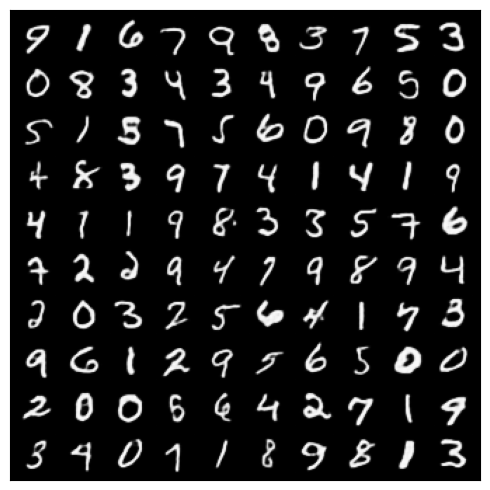

In [33]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

for image_batch, _ in test_dataloader:
    image_batch = image_batch.to(device)
    _, _, img_recon = vqvae(image_batch)
    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(make_grid(img_recon.cpu().data[:100],10,5))
    # plt.show()
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    break

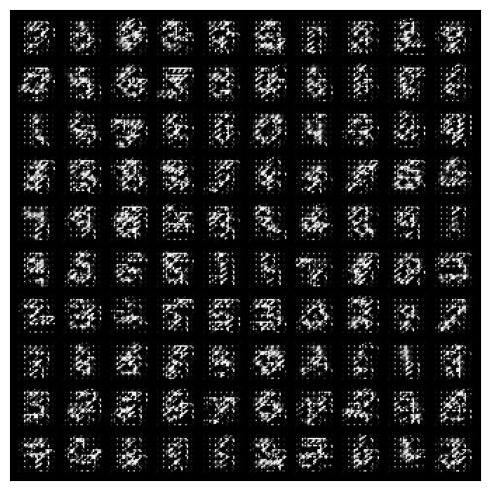

In [34]:
# latent_batch = generate_latent_batch(lstm, vqvae_collapsed, codebook=vqvae.vq.codebook, n=100)
# generated_samples = vqvae_collapsed.decoder(latent_batch)
fig, ax = plt.subplots(figsize=(5, 5))
# show_image(make_grid(generated_samples.detach().cpu(),10,5))
show_image(make_grid(vqvae_samples[50].detach().cpu(),10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('images/gen50_vqvae_selective_mi_codebook_0.2.png')

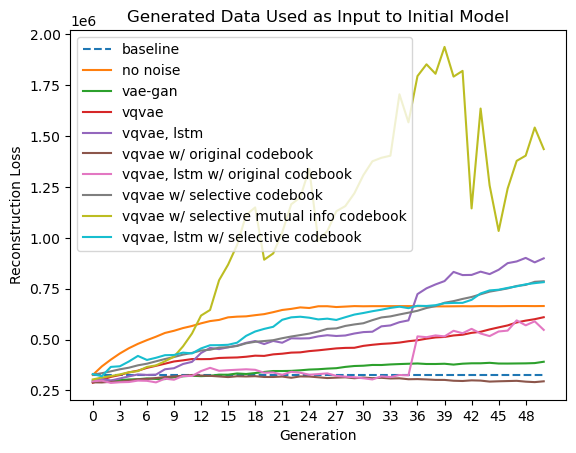

In [35]:
generations = 50
yscale = "linear"
losses = ['nonoise_50gen', 'gan_50gen', 'vqvae', 'vqvae_lstm', 'vqvae_codebook', 'vqvae_lstm_codebook', 'selective_codebook_vqvae', 'selective_mi_codebook_vqvae_0.2', 'selective_codebook_vqvae_lstm'] #, 'persistent_codebook_vqvae', 'persistent_codebook_vqvae_lstm']
labels = ['no noise', 'vae-gan', 'vqvae', 'vqvae, lstm', 'vqvae w/ original codebook', 'vqvae, lstm w/ original codebook', 'vqvae w/ selective codebook', 'vqvae w/ selective mutual info 0.2 codebook', 'vqvae, lstm w/ selective codebook'] #, 'vqvae w/ persistent codebook', 'vqvae, lstm w/ persistent codebook']
for i, suffix in enumerate(losses):
    input_path = os.path.join('outputs/tensors/', f"loss_{suffix}.pt")
    loss = torch.load(input_path, map_location=torch.device('cpu'))
    if i == 0:
        baseline = loss[0].item()
        plt.plot([baseline for _ in range(generations + 1)], label="baseline", linestyle="dashed")
    plt.plot([l.item() for l in loss], label=labels[i])

plt.legend()
plt.ylabel("Reconstruction Loss")
plt.xlabel("Generation")
plt.title("Generated Data Used as Input to Initial Model")
plt.xticks(range(0, generations + 1, (generations + 10) // 20))
plt.yscale(yscale)

plt.savefig('images/loss_init_vqvae.png')

In [36]:
info_threshold = 0.4
vqvae_samples, vqvae_loss_data = collapse(vae_init, vqvae, lstm, debug=True, start_codebooks=start_codebooks, generations=50)

Generation 0
tensor(0)
tensor(0.4462, device='cuda:0')
tensor(0.0343, device='cuda:0')
Generation 1
tensor(125, device='cuda:0')
tensor(0.4979, device='cuda:0')
tensor(3.5527e-15, device='cuda:0')
Generation 2
tensor(124, device='cuda:0')
tensor(0.4205, device='cuda:0')
tensor(0.0455, device='cuda:0')
Generation 3
tensor(126, device='cuda:0')
tensor(0.4680, device='cuda:0')
tensor(0.0457, device='cuda:0')
Generation 4
tensor(126, device='cuda:0')
tensor(0.4891, device='cuda:0')
tensor(0.0451, device='cuda:0')
Generation 5
tensor(124, device='cuda:0')
tensor(0.4581, device='cuda:0')
tensor(0.0248, device='cuda:0')
Generation 6
tensor(125, device='cuda:0')
tensor(0.4449, device='cuda:0')
tensor(0.0354, device='cuda:0')
Generation 7
tensor(126, device='cuda:0')
tensor(0.4953, device='cuda:0')
tensor(0.0556, device='cuda:0')
Generation 8
tensor(125, device='cuda:0')
tensor(0.4208, device='cuda:0')
tensor(0.0707, device='cuda:0')
Generation 9
tensor(127, device='cuda:0')
tensor(0.4664, devi

In [38]:
torch.save(vqvae_samples, 'outputs/tensors/samples_selective_mi_codebook_vqvae_0.4.pt')
torch.save(vqvae_loss_data, 'outputs/tensors/loss_selective_mi_codebook_vqvae_0.4.pt')

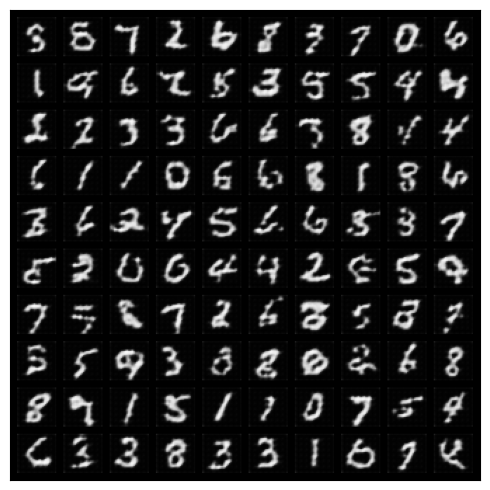

In [37]:
# latent_batch = generate_latent_batch(lstm, vqvae_collapsed, codebook=vqvae.vq.codebook, n=100)
# generated_samples = vqvae_collapsed.decoder(latent_batch)
fig, ax = plt.subplots(figsize=(5, 5))
# show_image(make_grid(generated_samples.detach().cpu(),10,5))
show_image(make_grid(vqvae_samples[50].detach().cpu(),10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('images/gen50_vqvae_selective_mi_codebook_0.4.png')

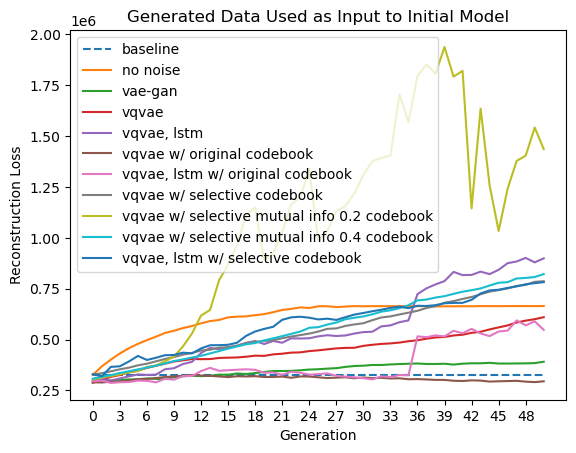

In [39]:
generations = 50
yscale = "linear"
losses = ['nonoise_50gen', 'gan_50gen', 'vqvae', 'vqvae_lstm', 'vqvae_codebook', 'vqvae_lstm_codebook', 'selective_codebook_vqvae', 'selective_mi_codebook_vqvae_0.2', 'selective_mi_codebook_vqvae_0.4', 'selective_codebook_vqvae_lstm'] #, 'persistent_codebook_vqvae', 'persistent_codebook_vqvae_lstm']
labels = ['no noise', 'vae-gan', 'vqvae', 'vqvae, lstm', 'vqvae w/ original codebook', 'vqvae, lstm w/ original codebook', 'vqvae w/ selective codebook', 'vqvae w/ selective mutual info 0.2 codebook', 'vqvae w/ selective mutual info 0.4 codebook', 'vqvae, lstm w/ selective codebook'] #, 'vqvae w/ persistent codebook', 'vqvae, lstm w/ persistent codebook']
for i, suffix in enumerate(losses):
    input_path = os.path.join('outputs/tensors/', f"loss_{suffix}.pt")
    loss = torch.load(input_path, map_location=torch.device('cpu'))
    if i == 0:
        baseline = loss[0].item()
        plt.plot([baseline for _ in range(generations + 1)], label="baseline", linestyle="dashed")
    plt.plot([l.item() for l in loss], label=labels[i])

plt.legend()
plt.ylabel("Reconstruction Loss")
plt.xlabel("Generation")
plt.title("Generated Data Used as Input to Initial Model")
plt.xticks(range(0, generations + 1, (generations + 10) // 20))
plt.yscale(yscale)

plt.savefig('images/loss_init_vqvae.png')